In [0]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
from fastprogress import progress_bar as pb

In [0]:
class DimentionalReducer(nn.Module):

    def __init__(self, in_dim, out_dim, in_channel, base_channel=64, k_size=2, stride=2):

        super(DimentionalReducer, self).__init__()

        self._in_dim = in_dim
        self._in_channel = in_channel
        self._base_channel = base_channel
        self._k_size = k_size
        self._stride = stride

        self._feat_layers = nn.ModuleDict({
            'layer1': nn.Sequential(
                nn.Conv1d(self._in_channel, self._base_channel, self._k_size, self._stride),
                nn.BatchNorm1d(self._base_channel),
                nn.LeakyReLU(negative_slope=0.1)
            ),
            'layer2': nn.Sequential(
                nn.Conv1d(self._base_channel, 2*self._base_channel, self._k_size, self._stride),
                nn.BatchNorm1d(2*self._base_channel),
                nn.LeakyReLU(negative_slope=0.1)
            ),
            'layer3': nn.Sequential(
                nn.Conv1d(2*self._base_channel, 4*self._base_channel, self._k_size, self._stride),
                nn.BatchNorm1d(4*self._base_channel),
                nn.LeakyReLU(negative_slope=0.1)
            ),
            'layer4': nn.Sequential(
                nn.Conv1d(4*self._base_channel, 8*self._base_channel, self._k_size, self._stride),
                nn.BatchNorm1d(8*self._base_channel),
                nn.LeakyReLU(negative_slope=0.1)
            )
        })

        reducer_in_dim = self._get_reducer_in_dim()

        self._reducer_layers = nn.Sequential(
            nn.Linear(reducer_in_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, out_dim),
            # nn.Tanh()
        )

    def forward(self, x):
        for layer in self._feat_layers.values():
            x = layer(x)
        x = x.view(x.shape[0], x.shape[1]*x.shape[2])
        x = self._reducer_layers(x)
        return x

    def _get_reducer_in_dim(self):
        dummy_data = torch.randn(3, self._in_channel, self._in_dim)
        for layer in self._feat_layers.values():
            dummy_data = layer(dummy_data)
        dummy_data = dummy_data.view(dummy_data.shape[0], -1)
        return dummy_data.shape[1]

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            m.weight.data.normal_(0.0, 0.02)
            m.bias.data.fill_(0)
        elif classname.find('Linear') != -1:
            m.weight.data.normal_(0.0, 0.02)
            m.bias.data.fill_(0)
        elif classname.find('BatchNorm') != -1:
            m.weight.data.normal_(1.0, 0.02)
            m.bias.data.fill_(0)

In [0]:
REDUCED_DIM = 2
BATCH_SIZE = 32

In [0]:
digits = datasets.load_digits()

In [0]:
data = digits.data
labels = digits.target

In [135]:
len(data)

1797

In [136]:
data[0].shape

(64,)

In [0]:
IN_DIM = 64
IN_CHANNEL = 1

In [0]:
dr = DimentionalReducer(
    in_dim=IN_DIM,
    out_dim=REDUCED_DIM,
    in_channel=IN_CHANNEL
)

In [139]:
torch.Tensor(data[:BATCH_SIZE]).unsqueeze(1).shape  # (batch_size, channel, data_dim)

torch.Size([32, 1, 64])

In [140]:
dr(torch.Tensor(data[:BATCH_SIZE]).unsqueeze(1)).shape  # (batch_size, REDUCED_DIM)

torch.Size([32, 2])

In [0]:
df_label = pd.DataFrame({
    'label': labels
})

In [142]:
df_label

,label
0,0
1,1
2,2
3,3
4,4
...,...
1792,9
1793,0
1794,8
1795,9


(178, 2)
(182, 2)
(177, 2)
(183, 2)
(181, 2)
(182, 2)
(181, 2)
(179, 2)
(174, 2)
(180, 2)


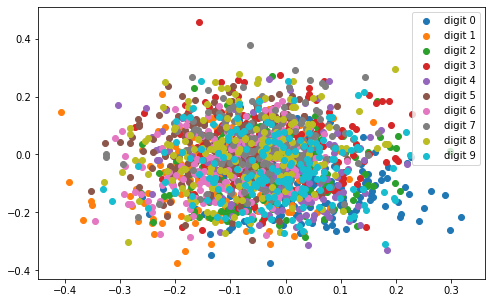

In [143]:
plt.figure(figsize=(8, 5))

for label in df_label['label'].unique():
    d = data[list(df_label['label'] == label)]
    d = torch.from_numpy(d).unsqueeze(1).float()
    d_reduced = dr(d).detach().numpy()
    plt.scatter(d_reduced[:, 0], d_reduced[:, 1], label=f'digit {label}')
    print(d_reduced.shape) 

plt.legend()

In [0]:
def get_sample_ids(anchor_cls, sampling_num):
    df_label_anchor_cls = df_label[df_label['label'] == anchor_cls]
    df_label_non_anchor_cls = df_label[df_label['label'] != anchor_cls]

    anchor_cls_ids = list(df_label_anchor_cls.sample(2*sampling_num).index)
    anchor_ids = anchor_cls_ids[:len(anchor_cls_ids)//2]
    positive_ids = anchor_cls_ids[len(anchor_cls_ids)//2:]

    negative_ids = list(df_label_non_anchor_cls.sample(sampling_num).index)

    return anchor_ids, positive_ids, negative_ids

In [145]:
get_sample_ids(2, 10)

([1689, 668, 1179, 1041, 371, 917, 979, 538, 243, 1417],
 [470, 369, 566, 22, 12, 333, 1490, 1299, 1718, 1655],
 [1442, 752, 568, 1167, 748, 37, 893, 1110, 1562, 1181])

In [0]:
MARGIN = 0.1

In [0]:
class TripletMarginLoss(nn.Module):

    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self._margin = margin

    def forward(self, anchor, positive, negative):
        loss = torch.sum(torch.pow((anchor - positive), 2) - torch.pow((anchor - negative), 2), dim=1)
        loss += self._margin
        loss = torch.clamp(loss, min=0.0)
        loss = torch.mean(loss)
        return loss

In [0]:
tm_loss = TripletMarginLoss(MARGIN)

In [0]:
optim = torch.optim.Adam(
    params=dr.parameters(),
    lr=0.001
)

In [152]:
ITER_N = 500

loss_history = []

dr.train()

for n in pb(range(ITER_N)):
    anchor_cls = int(df_label['label'].sample(1))
    anchor_ids, positive_ids, negative_ids = get_sample_ids(anchor_cls, BATCH_SIZE)
    anchor_data = torch.tensor(data[anchor_ids]).float().unsqueeze(1)
    positive_data = torch.tensor(data[positive_ids]).float().unsqueeze(1)
    negative_data = torch.tensor(data[negative_ids]).float().unsqueeze(1)
    
    anchor_reduced = dr(anchor_data)
    positive_reduced = dr(positive_data)
    negative_reduced = dr(negative_data)

    loss = tm_loss(anchor_reduced, positive_reduced, negative_reduced)

    optim.zero_grad()
    loss.backward()
    optim.step()

    loss_history.append(loss.item())

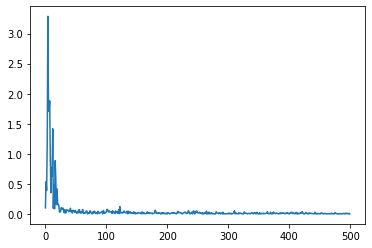

In [153]:
plt.plot(loss_history)

(178, 2)
(182, 2)
(177, 2)
(183, 2)
(181, 2)
(182, 2)
(181, 2)
(179, 2)
(174, 2)
(180, 2)


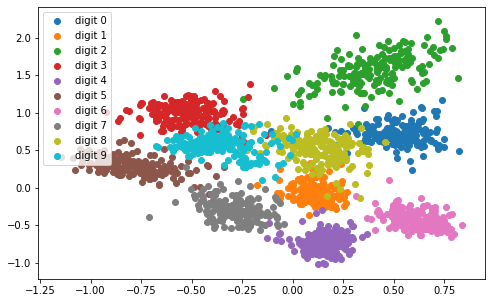

In [154]:
plt.figure(figsize=(8, 5))

for label in df_label['label'].unique():
    d = data[list(df_label['label'] == label)]
    d = torch.from_numpy(d).unsqueeze(1).float()
    d_reduced = dr(d).detach().numpy()
    plt.scatter(d_reduced[:, 0], d_reduced[:, 1], label=f'digit {label}')
    print(d_reduced.shape) 

plt.legend()